# Support Vector Machine Exercise
In this exercise you will learn about:
1. Implementing SVM from scratch using a sub-gradient method called Pegasos (2011)
2. The effect of imbalance and non-seperable classes on the SVM solution.
3. Pratical SVM in scikit-learn on a simple example including hyper parameter optimization wrapper class to find optimal regularization, loss and multiclass technique.
4. Optional reading material on one class, new probability interpretation of SVM

# 1. Implementing the PEGASOS SVM
We will implement the simplest SVM implementation. 
It is based on a paper by Shalev-Shwartz et al (see reading material below).
The essense of the algorithm is copied below from the paper:
![alt text](https://snag.gy/Gpi1Mk.jpg)

Here is a little more deailed explanation (it's recommended to read the full paper).
![alt_text](https://snag.gy/koA0ue.jpg)

1. Remember the SVM primal optimization problem in the linearly separable case is defined as
$$
\begin{align}
\min_{\mathbf{w},b}\quad &\frac{\|\mathbf{w}\|}{2}, \\
s.t.\quad&y^{(i)} (\mathbf{w^T}\mathbf{x}^{(i)}+b) \ge 1 &\forall i \in \{1,\dots,N\}
\end{align}
$$
Explain in words why in this case it is **not equivalent** to solve the original problem with a separate bias term $b$, and a reformulation of the problem using a padding of 1 to each sample (effectively ignoring the bias term in the original formulation, and letting the coordinate of $w$ which corresponds to the padding serve as the bias).

2. Implement a class *PegasosSVM* which has parameter $\lambda$ and $T$ and methods *fit* and *predict* and *decision_function* where the latter is the distance from the plane (aka model's output score).
  * **although the above**, here you are required to pad the samples with 1, and not use bias (the separating hyperplane must go through the origin).
  * don't forget labels should be {-1,1} - change them if it is {0,1}
  * don't forget to normalize your features. You can use [StandardScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) and [Pipeline](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html) to create a pipeline which first standartize features and then learn.

3. test your class on the breast cancer database [load_breast_cancer](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_breast_cancer.html), and compare your results to the Native Scikit-learn implementation [LinearSVC](https://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVC.html#sklearn.svm.LinearSVC)
  * you can use [`cross_val_score`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html)

4. Analyze the effect of the hyper parameter $\lambda$ on your training and test error. 
  * you can use scikit-learn's `validation_curve`

5. Analyze the learning curve (performance as function of training size)
  * you can use scikit-learn's `learning_curve`

6. *Bonus: Mini-batches* . In the paper, the authors summed the loss over several samples before updating. Extend your class to support mini-batches and analyze the perfomance effect if exists. See more details below

![](https://i.ibb.co/0BGwVz7/1.png)

#### Answer 1

Here a few word about it. Without the biais the the classifier will always goes through the origin.
If we pad with 1 our regularization term will never goes to the exact origin

#### Answer 2

In [303]:
from sklearn.base import BaseEstimator
from sklearn.base import ClassifierMixin
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score

class PegasosSVM(BaseEstimator):
    def __init__(self, lam = 1, T = 300):
        self.T = T 
        self.lam = lam
        self.scalar = StandardScaler()
        
    def fit(self, X, y):
        X = self._preprocess(X)
        self.W = np.zeros(X.shape[1])
        for t in range(1,self.T):
            i = np.random.randint(X.shape[0])
            eta_t = 1 / (self.lam * t)
            extra = (((y[i] * self.W @ X[i, :]) < 1).astype(float)) * eta_t * y[i] * X[i, :]
            self.W = (1 - 1 / t) * self.W + extra
        return self

    def predict(self, X):
        X = self._preprocess(X)
        y_hat = (X @ self.W.T > 0).astype(int)
        y_hat[y_hat==0] = -1
        return y_hat

    def decision_function(self, X):
        return X @ self.w
    
    def score(self, X, y):
        return accuracy_score(y, self.predict(X))
    
    def _preprocess(self, X):
        X = self.scalar.fit(X).transform(X)
        X = np.c_[X, np.ones(len(X))]
        return X

Answer 3 - test your class on the breast cancer database

In [296]:
import numpy as np
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import cross_val_score

In [297]:
data = load_breast_cancer()
X = data.data
y = data.target
y[y==0]=-1

Let's plot the original data (with correct prediction)

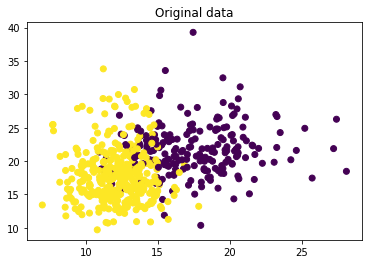

In [298]:
plt.scatter(X[:, 0], X[:, 1], c=y)
plt.title("Original data")
plt.show()

Here is our pregasosSvm prediction

In [304]:
psvm = PegasosSVM(1, 500)
psvm.fit(X, y)
y_pred = psvm.predict(X)

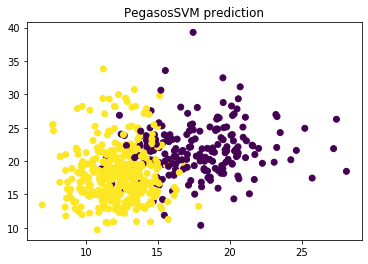

In [305]:
plt.scatter(X[:, 0], X[:, 1], c=y_pred)
plt.title("PegasosSVM prediction")
plt.show()

here is the score of PegasosSVM

In [306]:
psvc = PegasosSVM(1,100)
print('PegasosSVM cross validiation score:')
print(cross_val_score(psvc, X, y, cv=3).max())

PegasosSVM cross validiation score:
0.968421052631579


Here are score and prediction with LinearSVC

In [307]:
lsvc = LinearSVC(random_state=0, tol=1e-5, max_iter=1000)
lsvc.fit(X, y)
y_pred = lsvc.predict(X)
print('LinearSVC cross validiation score:')
print(cross_val_score(lsvc, X, y, cv=3).max())

LinearSVC cross validiation score:
0.9263157894736842


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


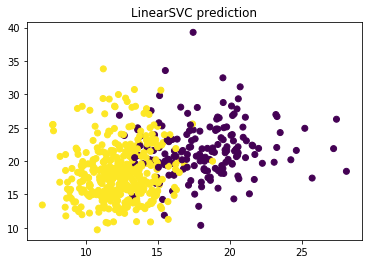

In [308]:
plt.scatter(X[:, 0], X[:, 1], c=y_pred)
plt.title("LinearSVC prediction")
plt.show()

#### Answer 4

In [310]:
from sklearn.model_selection import cross_val_score
lam_list = np.arange(0.01, 0.1, 0.01)
for lam in lam_list:
    psvc = PegasosSVM(lam, 100)
    print(f"for lambda {np.round(lam, 2)}:",cross_val_score(psvc, X, y, cv=3))

for lambda 0.01: [0.90526316 0.94736842 0.7989418 ]
for lambda 0.02: [0.86842105 0.93157895 0.83068783]
for lambda 0.03: [0.86842105 0.94736842 0.8994709 ]
for lambda 0.04: [0.87368421 0.96315789 0.83068783]
for lambda 0.05: [0.87894737 0.92631579 0.85714286]
for lambda 0.06: [0.86315789 0.96315789 0.87830688]
for lambda 0.07: [0.84736842 0.96842105 0.81481481]
for lambda 0.08: [0.88421053 0.94210526 0.85714286]
for lambda 0.09: [0.88947368 0.96842105 0.84126984]


# 2. The importance of class weighting in SVM
When classes are imbalance and not seperable, SVM might result in non intuitive solution.

To see this create a function `make_data` which generates a two dimensional dataset with `n_samples=1000` where a fraction `imbalance=0.1` is labeled `0` and the rest `1`. The distribution of $x$ given $y=0$ or $y=1$ is gaussian with std 0.5 or 2, respectively and that the centers are at $x_1=0$ and $x_2=-d/2$ and $x_2=d/2$, respectively. In other words,  
$$
p(x|y) = \mathcal{N}(\mu=(±d/2,0),\,\sigma=1/2+3/2\times y)
$$
and 
$$
p(y=0) = 0.1
$$. 

* For `d=10` and `d=2` plot the scatter plot of the data. Where would you think the SVM hyperplane will lie?

* Now, for each of these d, draw on top of the scatter the seperation hyperplane of the built-in LinearSVC in scikit-learn.

To plot the hyperplane, note that the fitted model has the `coef_` and `intercept_` properties.
Add also the `accuracy` and the `balanced_accuracy` metrics to the plot title.

* repeat the experiment but now set the `class_weight` to be `balanced`. 

Explain what was the problem and how changing class weight solved it.


In [329]:
def make_data(n_samples=1000, imbalance=0.1, d=10):
    num_of_class_zero = int(n_samples*imbalance)
    num_of_class_one = int(n_samples*(1-imbalance))
    X = []
    y = []
    class_zero_data = np.random.normal(loc=[0, -d/2], scale=0.5, size=(num_of_class_zero, 2))
    class_one_data = np.random.normal(loc=[0, d/2], scale=2, size=(num_of_class_one, 2))
    class_zero_label = np.zeros(shape=(num_of_class_zero, 1))
    class_ones_label = np.ones(shape=(num_of_class_one, 1))
    data = np.append(class_one_data, class_zero_data, axis=0)
    labels = np.append(class_ones_label, class_zero_label, axis=0)
    return data, labels

def draw_separator(coef_, intercept_):
    w = coef_[0]
    a = -w[0] / w[1]
    xx = np.linspace(-7, 7)
    yy = a * xx - (intercept_[0]) / w[1]
    plt.plot(xx, yy)
    bottom, top = plt.ylim()
    plt.fill_between(xx, yy,
                 top, alpha=0.2,
                 color='yellow')
    plt.fill_between(xx, yy,
                 bottom, alpha=0.2,
                 color='purple')

    

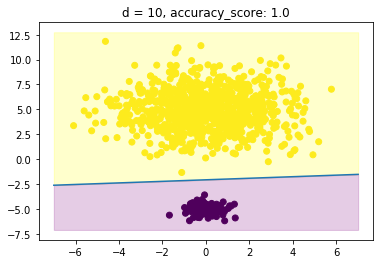

In [331]:
X, y = make_data(n_samples=1000, imbalance=0.1, d=10)
plt.scatter(X[:, 0], X[:, 1], c=y[:,0])
svc = LinearSVC(random_state=0, tol=1e-5).fit(X, y[:,0])
acc_score = accuracy_score(y, svc.predict(X))
draw_separator(svc.coef_, svc.intercept_)
plt.show()

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


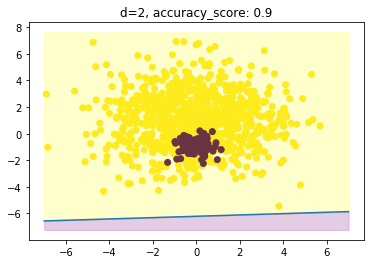

In [332]:
X, y = make_data(n_samples=1000, imbalance=0.1, d=2)
plt.scatter(X[:, 0], X[:, 1], c=y[:,0])
svc = LinearSVC(random_state=0, tol=1e-5).fit(X, y[:,0])
acc_score = accuracy_score(y, svc.predict(X))
plt.title(f"d=2, accuracy_score: {acc_score}")
draw_separator(svc.coef_, svc.intercept_)
plt.show()

All the sample are set in the same class because there is no weight

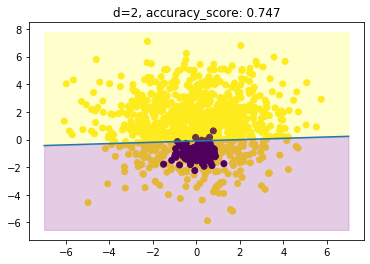

In [333]:
X, y = make_data(n_samples=1000, imbalance=0.1, d=2)
plt.scatter(X[:, 0], X[:, 1], c=y[:,0])
svc = LinearSVC(random_state=0, tol=1e-5, class_weight='balanced').fit(X, y[:,0])
acc_score = accuracy_score(y, svc.predict(X))
plt.title(f"d=2, accuracy_score: {acc_score}")
draw_separator(svc.coef_, svc.intercept_)
plt.show()

here is the result with balancing the weights

##3. SVM hyperparameter search
Machine learning pipelines in general and models in particular has several hyperparametrs that we currently do not know how to optimize.
Instead, researcher use grid search or random search techniques to find the optimal hyper parameters.
In this exercise you are requested to compare between default params model and a model which internally optimize for these hyper parameters.
Luckily, scikit-learn already has a ready class for doing that called `GridSearchCV`. Use the latter class to check all the combination of the following hyper parameters:
* `'multi_class':['ovr', 'crammer_singer']`
* `'loss':['hinge', 'squared_hinge']`
* `'C': np.logspace(-3,3,10)`

Compare the accuracy of the model to a default `LinearSVC` model with no hyper parameter optimization in terms of accuracy.

Note: Recall, that hyper parameter search is a learning procedure by itself, thus one should not use test data for the process. 

To do this you can use the handy `cross_val_score` function.


In [334]:
from sklearn.model_selection import GridSearchCV
parameters = {'multi_class':['ovr', 'crammer_singer'],
              'loss':['hinge', 'squared_hinge'],
              'C': np.logspace(-3,3,10)}
svc = LinearSVC(max_iter=10000)
clf = GridSearchCV(svc, parameters)
clf.fit(X, y[:,0])

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarn

GridSearchCV(cv='warn', error_score='raise-deprecating',
             estimator=LinearSVC(C=1.0, class_weight=None, dual=True,
                                 fit_intercept=True, intercept_scaling=1,
                                 loss='squared_hinge', max_iter=10000,
                                 multi_class='ovr', penalty='l2',
                                 random_state=None, tol=0.0001, verbose=0),
             iid='warn', n_jobs=None,
             param_grid={'C': array([1.00000000e-03, 4.64158883e-03, 2.15443469e-02, 1.00000000e-01,
       4.64158883e-01, 2.15443469e+00, 1.00000000e+01, 4.64158883e+01,
       2.15443469e+02, 1.00000000e+03]),
                         'loss': ['hinge', 'squared_hinge'],
                         'multi_class': ['ovr', 'crammer_singer']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [335]:
import pandas as pd
pd.set_option('display.max_colwidth', -1)
results = pd.DataFrame(clf.cv_results_)
results[['params','mean_test_score','rank_test_score']].sort_values(by=['mean_test_score'], ascending=False)

,params,mean_test_score,rank_test_score
20,"{'C': 2.154434690031882, 'loss': 'hinge', 'multi_class': 'ovr'}",0.900,1
29,"{'C': 46.41588833612773, 'loss': 'hinge', 'multi_class': 'crammer_singer'}",0.900,1
21,"{'C': 2.154434690031882, 'loss': 'hinge', 'multi_class': 'crammer_singer'}",0.900,1
23,"{'C': 2.154434690031882, 'loss': 'squared_hinge', 'multi_class': 'crammer_singer'}",0.900,1
24,"{'C': 10.0, 'loss': 'hinge', 'multi_class': 'ovr'}",0.900,1
25,"{'C': 10.0, 'loss': 'hinge', 'multi_class': 'crammer_singer'}",0.900,1
27,"{'C': 10.0, 'loss': 'squared_hinge', 'multi_class': 'crammer_singer'}",0.900,1
28,"{'C': 46.41588833612773, 'loss': 'hinge', 'multi_class': 'ovr'}",0.900,1
30,"{'C': 46.41588833612773, 'loss': 'squared_hinge', 'multi_class': 'ovr'}",0.900,1
17,"{'C': 0.46415888336127775, 'loss': 'hinge', 'multi_class': 'crammer_singer'}",0.900,1


# 4. Optional Reading Materials
1. Shalev-Shwartz, S., Singer, Y., Srebro, N., & Cotter, A. (2011). Pegasos: Primal estimated sub-gradient solver for svm. Mathematical programming, 127(1), 3-30. [[pdf](http://www.ee.oulu.fi/research/imag/courses/Vedaldi/ShalevSiSr07.pdf)]

2. Schölkopf, B., Williamson, R. C., Smola, A. J., Shawe-Taylor, J., & Platt, J. C. (2000). Support vector method for novelty detection. In Advances in neural information processing systems (pp. 582-588). [[pdf](http://papers.nips.cc/paper/1723-support-vector-method-for-novelty-detection.pdf)]

3. Livni, R., Crammer, K. & Globerson, A.. (2012). A Simple Geometric Interpretation of SVM using Stochastic Adversaries. Proceedings of the Fifteenth International Conference on Artificial Intelligence and Statistics, in PMLR 22:722-730. [[pdf](http://proceedings.mlr.press/v22/livni12/livni12.pdf)]

